# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-11-20 21:28:23,552|IRAHoldingsAdjustement|INFO|Python version: 3.8.8
2022-11-20 21:28:23,554|IRAHoldingsAdjustement|INFO|Pandas version: 1.2.4


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-20 21:28:23,583|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-20 21:28:24,812|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-20 00:00:00|2022-11-18 00:00:00
2022-11-20 21:28:24,851|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-11-20 21:28:24,903|IRAHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-20 21:28:24,904|IRAHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-20 21:28:25,106|IRAHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-20 21:28:25,126|IRAHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.08
2022-11-20 21:28:25,128|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.15
2022-11-20 21:28:25,129|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-20 21:32:11,565|IRAHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.85|501->427


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-20 21:32:11,597|IRAHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|427
2022-11-20 21:32:11,655|IRAHoldingsAdjustement|INFO|OPT_DATE|2022-11-18 00:00:00


2022-11-20 21:32:24,747|IRAHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01307027


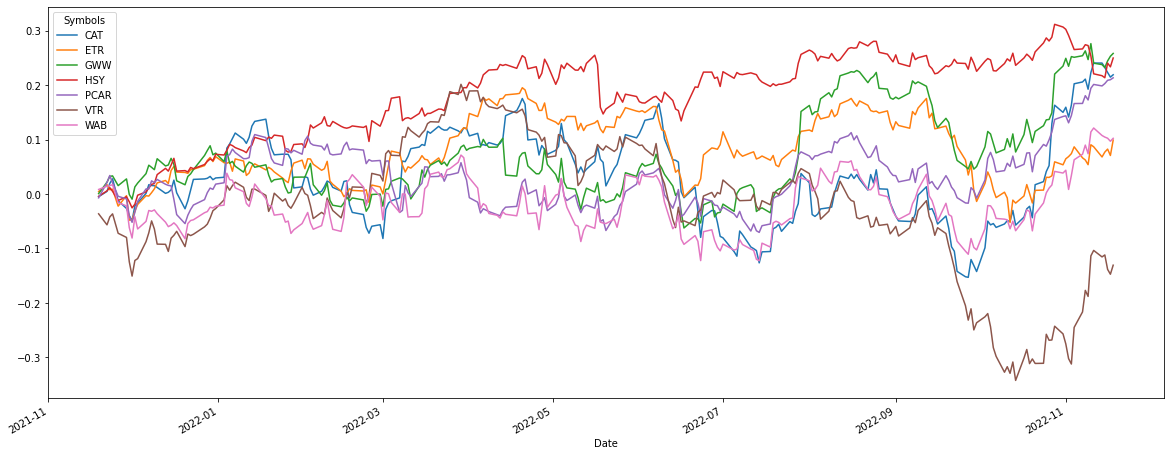

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-20 21:32:25,038|IRAHoldingsAdjustement|INFO|STOCK|CAT                 |HOLDING|0.100000
2022-11-20 21:32:25,038|IRAHoldingsAdjustement|INFO|STOCK|ETR                 |HOLDING|0.150000
2022-11-20 21:32:25,038|IRAHoldingsAdjustement|INFO|STOCK|GWW                 |HOLDING|0.150000
2022-11-20 21:32:25,038|IRAHoldingsAdjustement|INFO|STOCK|HSY                 |HOLDING|0.150000
2022-11-20 21:32:25,051|IRAHoldingsAdjustement|INFO|STOCK|PCAR                |HOLDING|0.150000
2022-11-20 21:32:25,052|IRAHoldingsAdjustement|INFO|STOCK|VTR                 |HOLDING|0.150000
2022-11-20 21:32:25,052|IRAHoldingsAdjustement|INFO|STOCK|WAB                 |HOLDING|0.150000


In [9]:
import ameritrade_functions as amc
import utils

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

2022-11-20 21:32:25,159|WDM|INFO|



====== WebDriver manager ======


2022-11-20 21:32:25,161|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-20 21:32:25,189|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-20 21:32:25,190|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-20 21:32:25,347|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,693718108,PCAR,PACCAR Inc. - Common Stock,NASDAQ,EQUITY,104.970,77.00,1.480,1.42,2022-11-14 00:00:00.000,...,11.55336,0.0,0.0,0.0,0.370,2022-12-06 00:00:00.000,0.90702,2411070.0,2411074.0,42097820.0
1,29364G103,ETR,Entergy Corporation Common Stock,NYSE,EQUITY,126.815,94.94,4.280,3.82,2022-11-10 00:00:00.000,...,4.93359,0.0,0.0,0.0,1.070,2022-12-01 00:00:00.000,0.62159,1121350.0,1121349.0,24871780.0
2,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.33,1.800,4.08,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.16199,2548040.0,2548037.0,46970510.0
3,384802104,GWW,"W.W. Grainger, Inc. Common Stock",NYSE,EQUITY,612.060,440.48,6.880,1.15,2022-11-10 00:00:00.000,...,3.65558,0.0,0.0,0.0,1.720,2022-12-01 00:00:00.000,1.23424,313370.0,313371.0,7240430.0
4,149123101,CAT,"Caterpillar, Inc. Common Stock",NYSE,EQUITY,239.850,160.60,4.800,2.07,2022-10-21 00:00:00.000,...,6.54915,0.0,0.0,0.0,1.200,2022-11-18 00:00:00.000,1.11983,3728390.0,3728393.0,66497680.0
5,929740108,WAB,Westinghouse Air Brake Technologies Corporatio...,NYSE,EQUITY,102.110,78.26,0.600,0.61,2022-11-10 00:00:00.000,...,18.88636,0.0,0.0,0.0,0.150,2022-11-28 00:00:00.000,1.49413,1043350.0,1043345.0,18500300.0
6,427866108,HSY,The Hershey Company Common Stock,NYSE,EQUITY,241.450,175.08,4.144,1.84,2022-11-17 00:00:00.000,...,29.29452,0.0,0.0,0.0,1.036,2022-12-15 00:00:00.000,0.35304,1312470.0,1312471.0,20067850.0


Tickers:   0%|          | 0/7 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

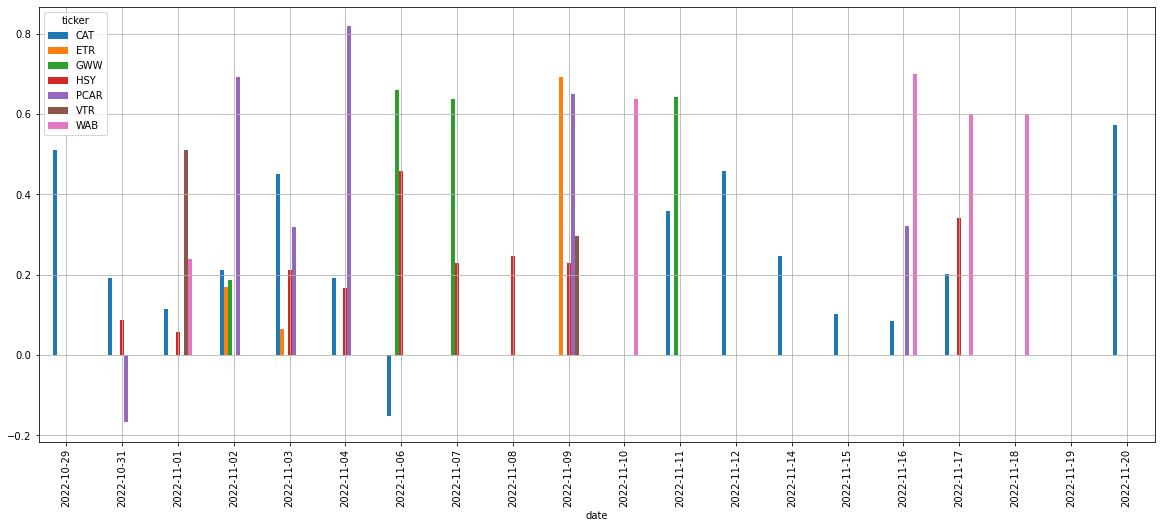

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error(f'Error: No authorization data: {td_ameritrade.authorization}')
    raise Exeption
else:
    logger.info('You have authorization')

2022-11-20 21:33:13,081|WDM|INFO|



====== WebDriver manager ======


2022-11-20 21:33:13,086|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-20 21:33:13,118|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-20 21:33:13,120|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-20 21:33:13,183|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-20 21:33:52,017|IRAHoldingsAdjustement|INFO|You have authorization


In [12]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-11-20 21:33:52,039|IRAHoldingsAdjustement|INFO|TRADE_DATE|2022-11-20 21:33:52.039888
2022-11-20 21:33:54,356|IRAHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 SCHF              0.0      35.56279             0.0   
         VTIP              0.0      52.14316             0.0   
         WRB               0.0      69.81509             0.0   
         MCK               0.0     364.72571             0.0   
         VGK               0.0      59.10313             0.0   
         FNCL              0.0      40.44691             0.0   
         FSTA              0.0      42.61006             0.0   
         SCHM              0.0      77.86802             0.0   
         VWO               0.0      50.42377             0.0   
         VBR               0.0     169.07886             0.0   
         FGPHF             0.0       0.12293             0.0   
         FFIV              0.0     149.55520             0.0   
         WKHS              0.0      12.43990             0.0   
         RSG               0.0     132.26429             0.0   
         EEENF             0.0       0.04960             0.0   
         JNJ               0.0     172.09591             0.0   
         VOO               0.0     370.43264             0.0   
         IRM               0.0      52.34500             0.0   
         FISV              0.0     100.25568             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 SCHF                     0.0                             0.0   
         VTIP                     0.0                             0.0   
         WRB                      0.0                             0.0   
         MCK                      0.0                             0.0   
         VGK                      0.0                             0.0   
         FNCL                     0.0                             0.0   
         FSTA                     0.0                             0.0   
         SCHM                     0.0                             0.0   
         VWO                      0.0                             0.0   
         VBR                      0.0                             0.0   
         FGPHF                    0.0                             0.0   
         FFIV                     0.0                             0.0   
         WKHS                     0.0                             0.0   
         RSG                      0.0                             0.0   
         EEENF                    0.0                             0.0   
         JNJ                      0.0                             0.0   
         VOO                      0.0                             0.0   
         IRM                      0.0                             0.0   
         FISV                     0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 SCHF          60.707               60.707                   0.0   
         VTIP          71.973               71.973                   0.0   
         WRB           53.000               53.000                   0.0   
         MCK            7.000                7.000                   0.0   
         VGK           35.925               35.925                   0.0   
         FNCL          13.224               13.224                   0.0   
         FSTA           5.088                5.088                   0.0   
         SCHM          20.291               20.291                   0.0   
         VWO           15.362               15.362                   0.0   
         VBR            3.094                3.094                   0.0   
         FGPHF     100000.000           100000.000                   0.0   
         FFIV          25.000               25.000                   0.0   
         WKHS        1000.000             1000.000                   0.0  

In [13]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

2022-11-20 21:33:54,658|IRAHoldingsAdjustement|INFO|Stocks to sell:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 WRB               0.0      69.81509             0.0   
         MCK               0.0     364.72571             0.0   
         FFIV              0.0     149.55520             0.0   
         RSG               0.0     132.26429             0.0   
         JNJ               0.0     172.09591             0.0   
         IRM               0.0      52.34500             0.0   
         FISV              0.0     100.25568             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 WRB                      0.0                             0.0   
         MCK                      0.0                             0.0   
         FFIV                     0.0                             0.0   
         RSG                      0.0                             0.0   
         JNJ                      0.0                             0.0   
         IRM                      0.0                             0.0   
         FISV                     0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 WRB             53.0                 53.0                   0.0   
         MCK              7.0                  7.0                   0.0   
         FFIV            25.0                 25.0                   0.0   
         RSG             28.0                 28.0                   0.0   
         JNJ             22.0                 22.0                   0.0   
         IRM             70.0                 70.0                   0.0   
         FISV            37.0                 37.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---5311 WRB         3886.49                 3886.49   
         MCK         2588.11                 2588.11   
         FFIV        3734.25                 3734.25   
         RSG         3748.92                 3748.92   
         JNJ         3876.40                 3876.40   
         IRM         3661.00                 3661.00   
         FISV        3694.82                 3694.82   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---5311 WRB                            53.0    EQUITY  084423102           0   
         MCK                             7.0    EQUITY  58155Q103           0   
         FFIV                           25.0    EQUITY  315616102           0   
         RSG                            28.0    EQUITY  760759100           0   
         JNJ                            22.0    EQUITY  478160104           0   
         IRM                            70.0    EQUITY  46284V101           0   
         FISV                           37.0    EQUITY  337738108           0   

                type  
account  symbol       
#---5311 WRB       0  
         MCK       0  
         FFIV      0  
         RSG       0  
         JNJ       0  
         IRM       0  
         FISV      0

In [41]:
38.2213630676269 * 148158800.00000

5662831286.463921

In [44]:
test_data_df = pd.read_csv('./tools/tests/test_data/test_data.csv', header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)

In [45]:
test_data_df

Attributes Adj_Ratio           Close                    High               \
Symbols         AAPL GOOG       AAPL         GOOG       AAPL         GOOG   
Date                                                                        
2019-01-02  0.968120  1.0  38.221363  1045.849976  38.446453  1052.319946   
2019-01-03  0.968120  1.0  34.414234  1016.059998  35.268599  1056.979980   
2019-01-04  0.968120  1.0  35.883362  1070.709961  35.953553  1070.839966   
2019-01-07  0.968120  1.0  35.803493  1068.390015  36.021323  1074.000000   
2019-01-08  0.968120  1.0  36.486012  1076.280029  36.744985  1084.560059   
...              ...  ...        ...          ...        ...          ...   
2019-12-24  0.982666  1.0  69.835602  1343.560059  69.987921  1350.260010   
2019-12-26  0.982666  1.0  71.221161  1360.400024  71.238359  1361.327026   
2019-12-27  0.982666  1.0  71.194122  1351.890015  72.218555  1364.530029   
2019-12-30  0.982666  1.0  71.616692  1336.140015  71.904125  1353.000000   
2019-12-31  0.982666  1.0  72.139938  1337.020020  72.147308  1338.000000   

Attributes        Low                    Open                    Volume  \
Symbols          AAPL         GOOG       AAPL         GOOG         AAPL   
Date                                                                      
2019-01-02  37.328272  1015.710022  37.488013  1016.570007  148158800.0   
2019-01-03  34.368248  1014.070007  34.847466  1041.000000  365248800.0   
2019-01-04  34.803910  1027.417969  34.980591  1032.589966  234428400.0   
2019-01-07  35.312173  1054.760010  35.989858  1071.500000  219111200.0   
2019-01-08  35.946286  1060.530029  36.197995  1076.109985  164101200.0   
...               ...          ...        ...          ...          ...   
2019-12-24  69.503958  1342.780029  69.938785  1348.500000   48478800.0   
2019-12-26  69.941241  1344.469971  69.970720  1346.170044   93121200.0   
2019-12-27  70.781405  1349.310059  71.518404  1362.989990  146266000.0   
2019-12-30  70.068996  1334.020020  71.110619  1350.000000  144114400.0   
2019-12-31  71.125335  1329.084961  71.226059  1330.109985  100805600.0   

Attributes             
Symbols          GOOG  
Date                   
2019-01-02  1532600.0  
2019-01-03  1841100.0  
2019-01-04  2093900.0  
2019-01-07  1981900.0  
2019-01-08  1764900.0  
...               ...  
2019-12-24   347500.0  
2019-12-26   667500.0  
2019-12-27  1038400.0  
2019-12-30  1050900.0  
2019-12-31   961800.0  

[252 rows x 12 columns]

### Submit and montior sell orders

In [26]:
import importlib
importlib.reload(amc)

<module 'ameritrade_functions' from 'c:\\users\\hp-z440\\anaconda projects\\svi-trading-tools\\tools\\ameritrade_functions.py'>

In [27]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

2022-11-20 22:06:08,782|WDM|INFO|



====== WebDriver manager ======


2022-11-20 22:06:08,785|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-20 22:06:08,822|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-20 22:06:08,823|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-20 22:06:08,894|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing SELL order on #---5311 for 53.0 shares of WRB...
Placed SELL order on #---5311 for 53.0 shares of WRB
Placing SELL order on #---5311 for 7.0 shares of MCK...
Placed SELL order on #---5311 for 7.0 shares of MCK
Placing SELL order on #---5311 for 25.0 shares of FFIV...
Placed SELL order on #---5311 for 25.0 shares of FFIV
Placing SELL order on #---5311 for 28.0 shares of RSG...
Placed SELL order on #---5311 for 28.0 shares of RSG
Placing SELL order on #---5311 for 22.0 shares of JNJ...
Placed SELL order on #---5311 for 22.0 shares of JNJ
Placing SELL order on #---5311 for 70.0 shares of IRM...
Placed SELL order on #---5311 for 70.0 shares of IRM
Placing SELL order on #---5311 for 37.0 shares of FISV...
Placed SELL order on #---5311 for 37.0 shares of FISV


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [29]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

2022-11-21 09:49:37,984|WDM|INFO|



====== WebDriver manager ======


2022-11-21 09:49:37,989|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-21 09:49:38,031|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-21 09:49:38,033|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-21 09:49:38,146|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             92434.450000
initialBalances_moneyMarketFund      831.410000
currentBalances_cashBalance        25171.320000
currentBalances_equity             92127.930000
currentBalances_moneyMarketFund      831.410000
current_return                        -0.003322
Name: #---5311, dtype: float64

25171.32
831.41
2022-11-21 09:50:17,330|IRAHoldingsAdjustement|INFO|INVESTMENT_AMT|26002.73


In [30]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 26002.73
Amount to invest: 26000


In [31]:
long_weights

,optimalWeights
CAT,0.10
ETR,0.15
GWW,0.15
HSY,0.15
PCAR,0.15
VTR,0.15
WAB,0.15


In [32]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-21 09:50:34.485364
Initial investment amount: 26000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
CAT,231.43,0.10,2600.0,11
ETR,111.92,0.15,3900.0,34
GWW,597.03,0.15,3900.0,6
HSY,225.21,0.15,3900.0,17
PCAR,103.87,0.15,3900.0,37
VTR,44.07,0.15,3900.0,88
WAB,99.16,0.15,3900.0,39


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
CAT,231.43,0.10,2600.0,11,2545.73
ETR,111.92,0.15,3900.0,34,3805.28
GWW,597.03,0.15,3900.0,6,3582.18
HSY,225.21,0.15,3900.0,17,3828.57
PCAR,103.87,0.15,3900.0,37,3843.19
VTR,44.07,0.15,3900.0,88,3878.16
WAB,99.16,0.15,3900.0,39,3867.24


Total cost: 25350.35


### Place buy orders

In [33]:
amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,693718108,PCAR,PACCAR Inc. - Common Stock,NASDAQ,EQUITY,104.970,77.00,1.480,1.42,2022-11-14 00:00:00.000,...,11.55336,0.0,0.0,0.0,0.370,2022-12-06 00:00:00.000,0.90702,2411070.0,2411074.0,42097820.0
1,29364G103,ETR,Entergy Corporation Common Stock,NYSE,EQUITY,126.815,94.94,4.280,3.82,2022-11-10 00:00:00.000,...,4.93359,0.0,0.0,0.0,1.070,2022-12-01 00:00:00.000,0.62159,1121350.0,1121349.0,24871780.0
2,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.33,1.800,4.08,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.16199,2548040.0,2548037.0,46970510.0
3,384802104,GWW,"W.W. Grainger, Inc. Common Stock",NYSE,EQUITY,612.060,440.48,6.880,1.15,2022-11-10 00:00:00.000,...,3.65558,0.0,0.0,0.0,1.720,2022-12-01 00:00:00.000,1.23424,313370.0,313371.0,7240430.0
4,149123101,CAT,"Caterpillar, Inc. Common Stock",NYSE,EQUITY,239.850,160.60,4.800,2.07,2022-10-21 00:00:00.000,...,6.54915,0.0,0.0,0.0,1.200,2022-11-18 00:00:00.000,1.11983,3728390.0,3728393.0,66497680.0
5,929740108,WAB,Westinghouse Air Brake Technologies Corporatio...,NYSE,EQUITY,102.110,78.26,0.600,0.61,2022-11-10 00:00:00.000,...,18.88636,0.0,0.0,0.0,0.150,2022-11-28 00:00:00.000,1.49413,1043350.0,1043345.0,18500300.0
6,427866108,HSY,The Hershey Company Common Stock,NYSE,EQUITY,241.450,175.08,4.144,1.84,2022-11-17 00:00:00.000,...,29.29452,0.0,0.0,0.0,1.036,2022-12-15 00:00:00.000,0.35304,1312470.0,1312471.0,20067850.0


In [34]:
print(datetime.today())
#td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
#td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-21 09:51:00.339430
Placing BUY order on 495855311 for 11.0 shares of CAT:EQUITY...
Placed BUY order on #---5311 for 11.0 shares of CAT
Placing BUY order on 495855311 for 34.0 shares of ETR:EQUITY...
Placed BUY order on #---5311 for 34.0 shares of ETR
Placing BUY order on 495855311 for 6.0 shares of GWW:EQUITY...
Placed BUY order on #---5311 for 6.0 shares of GWW
Placing BUY order on 495855311 for 17.0 shares of HSY:EQUITY...
Placed BUY order on #---5311 for 17.0 shares of HSY
Placing BUY order on 495855311 for 37.0 shares of PCAR:EQUITY...
Placed BUY order on #---5311 for 37.0 shares of PCAR
Placing BUY order on 495855311 for 88.0 shares of VTR:EQUITY...
Placed BUY order on #---5311 for 88.0 shares of VTR
Placing BUY order on 495855311 for 39.0 shares of WAB:EQUITY...
Placed BUY order on #---5311 for 39.0 shares of WAB


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]